# Qiskit Machine Learning Module - Quantum Neural Network

### June 14, 2023 
### For SCQC Summer School 2023: Day 3
This tutorial was generated from Qiskit Machine learning docs
https://qiskit.org/ecosystem/machine-learning/tutorials/01_neural_networks.html

# Quantum Neural Networks

## Overview
This notebook demonstrates different quantum neural network (QNN) implementations provided in `qiskit-machine-learning`, and how they can be integrated into basic quantum machine learning (QML) workflows.

The tutorial is structured as follows:

1. [Introduction](#1.-Implementation-in-`qiskit-machine-learning`)
2. [SamplerQNN](#2.`SamplerQNN`)
3. [How to Run a Forward Pass](#3.-How-to-Run-a-Forward-Pass)
4. [How to Run a Backward Pass](#4.-How-to-Run-a-Backward-Pass)
5. [Advanced Functionality](#5.-Advanced-Functionality)
6. [Conclusion](#6.-Conclusion)

## 1. Implementation in `qiskit-machine-learning`

The QNNs in `qiskit-machine-learning` are meant as application-agnostic computational units that can be used for different use cases.

The module contains an interface for the QNNs and two specific implementations:

1. [NeuralNetwork](https://qiskit.org/ecosystem/machine-learning/stubs/qiskit_machine_learning.neural_networks.NeuralNetwork.html): The interface for neural networks. This is an abstract class all QNNs inherit from.
2. [EstimatorQNN](https://qiskit.org/ecosystem/machine-learning/stubs/qiskit_machine_learning.neural_networks.EstimatorQNN.html): A network based on the evaluation of quantum mechanical observables.
3. [SamplerQNN](https://qiskit.org/ecosystem/machine-learning/locale/fr_FR/stubs/qiskit_machine_learning.neural_networks.SamplerQNN.html): A network based on the samples resulting from measuring a quantum circuit.


These implementations are based on the [qiskit primitives](https://qiskit.org/documentation/apidoc/primitives.html).
 Each implementation, `EstimatorQNN` and `SamplerQNN`, takes in an optional instance of its corresponding primitive, which can be any subclass of `BaseEstimator` and `BaseSampler`, respectively.

***

Let's now look into specific examples for the two `NeuralNetwork` implementations. But first, let's set the algorithmic seed to ensure that the results don't change between runs.

In [1]:
from qiskit.utils import algorithm_globals

algorithm_globals.random_seed = 42

## 2. `SamplerQNN`

`SamplerQNN` is instantiated in a similar way to the `EstimatorQNN`
  - but because it directly consumes samples from measuring the quantum circuit, it does not require a custom observable.

These output samples are interpreted by default as the probabilities of measuring the integer index corresponding to a bitstring. 

However, the `SamplerQNN` also allows us to specify an `interpret` function to post-process the samples. This function should be defined so that it takes a measured integer (from a bitstring) and maps it to a new value, i.e. non-negative integer.



Let's create a quantum circuit for the `SamplerQNN`. In this case, we will have two input parameters and four trainable weights that parametrize a  two-local circuit.

input parameters: ['input[0]', 'input[1]']
weight parameters: ['weight[0]', 'weight[1]', 'weight[2]', 'weight[3]']


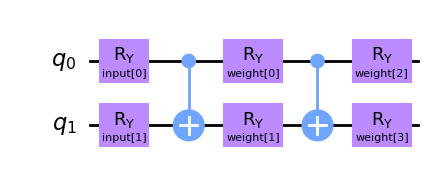

In [5]:
from qiskit.circuit import QuantumCircuit, ParameterVector

inputs2 = ParameterVector("input", 2)
weights2 = ParameterVector("weight", 4)
print(f"input parameters: {[str(item) for item in inputs2.params]}")
print(f"weight parameters: {[str(item) for item in weights2.params]}")

qc2 = QuantumCircuit(2)
qc2.ry(inputs2[0], 0)
qc2.ry(inputs2[1], 1)
qc2.cx(0, 1)
qc2.ry(weights2[0], 0)
qc2.ry(weights2[1], 1)
qc2.cx(0, 1)
qc2.ry(weights2[2], 0)
qc2.ry(weights2[3], 1)

qc2.draw(output="mpl")

Similarly to the `EstimatorQNN`, we must specify inputs and weights when instantiating the `SamplerQNN`. In this case, the keyword arguments will be:
- `sampler`: optional primitive instance
- `input_params`: list of quantum circuit parameters that should be treated as "network inputs"
- `weight_params`: list of quantum circuit parameters that should be treated as "network weights"

Please note that, once again, we are choosing not to set the `Sampler` instance to the QNN and relying on the default.

In [7]:
from qiskit_machine_learning.neural_networks import SamplerQNN

sampler_qnn = SamplerQNN(circuit=qc2, input_params=inputs2, weight_params=weights2)
sampler_qnn

In addition to the basic arguments shown above, the `SamplerQNN` accepts three more settings: `input_gradients`, `interpret`, and `output_shape`. These will be introduced in sections 4 and 5.

## 3. How to Run a Forward Pass

### 3.1. Set-Up
In a real setting, the inputs would be defined by the dataset, and the weights would be defined by the training algorithm or as part of a pre-trained model. However, for the sake of this tutorial, we will specify random sets of input and weights of the right dimension:

In [8]:
sampler_qnn_input = algorithm_globals.random.random(sampler_qnn.num_inputs)
sampler_qnn_weights = algorithm_globals.random.random(sampler_qnn.num_weights)

In [9]:
print(
    f"Number of input features for SamplerQNN: {sampler_qnn.num_inputs} \nInput: {sampler_qnn_input}"
)
print(
    f"Number of trainable weights for SamplerQNN: {sampler_qnn.num_weights} \nWeights: {sampler_qnn_weights}"
)

Number of input features for SamplerQNN: 2 
Input: [0.77395605 0.43887844]
Number of trainable weights for SamplerQNN: 4 
Weights: [0.85859792 0.69736803 0.09417735 0.97562235]


Once we have the inputs and the weights, let's see the results for batched and non-batched passes.

### 3.2. Non-batched Forward Pass

For the `SamplerQNN` (without a custom interpret function), the expected output shape for the forward pass is `(1, 2**num_qubits)`. With a custom interpret function, the output shape will be `(1, output_shape)`, where `1` in our case is the number of samples:

In [10]:
sampler_qnn_forward = sampler_qnn.forward(sampler_qnn_input, sampler_qnn_weights)

print(
    f"Forward pass result for SamplerQNN: {sampler_qnn_forward}.  \nShape: {sampler_qnn_forward.shape}"
)

Forward pass result for SamplerQNN: [[0.23851185 0.1411135  0.3367757  0.28359895]].  
Shape: (1, 4)


### 3.3. Batched Forward Pass

For the `SamplerQNN` (without custom interpret function), the expected output shape for the forward pass is `(batch_size, 2**num_qubits)`. With a custom interpret function, the output shape will be `(batch_size, output_shape)`.

In [11]:
sampler_qnn_forward_batched = sampler_qnn.forward(
    [sampler_qnn_input, sampler_qnn_input], sampler_qnn_weights
)

print(
    f"Forward pass result for SamplerQNN: {sampler_qnn_forward_batched}.  \nShape: {sampler_qnn_forward_batched.shape}"
)

Forward pass result for SamplerQNN: [[0.23851185 0.1411135  0.3367757  0.28359895]
 [0.23851185 0.1411135  0.3367757  0.28359895]].  
Shape: (2, 4)


## 4. How to Run a Backward Pass

Let's take advantage of the inputs and weights defined above to show how the backward pass works. This pass returns a tuple `(input_gradients, weight_gradients)`. By default, the backward pass will only calculate gradients with respect to the weight parameters.

If you want to enable gradients with respect to the input parameters, you should set the following flag during the QNN instantiation:

```python
qnn = ...QNN(..., input_gradients=True)
```

Please remember that input gradients are **required** for the use of `TorchConnector` for PyTorch integration.

### 4.1. Backward Pass without Input Gradients

For the `SamplerQNN` (without custom interpret function), the expected output shape for the forward pass is `(batch_size, 2**num_qubits, num_weights)`. With a custom interpret function, the output shape will be `(batch_size, output_shape, num_weights)`.:

In [12]:
sampler_qnn_input_grad, sampler_qnn_weight_grad = sampler_qnn.backward(
    sampler_qnn_input, sampler_qnn_weights
)

print(
    f"Input gradients for SamplerQNN: {sampler_qnn_input_grad}.  \nShape: {sampler_qnn_input_grad}"
)
print(
    f"Weight gradients for SamplerQNN: {sampler_qnn_weight_grad}.  \nShape: {sampler_qnn_weight_grad.shape}"
)

Input gradients for SamplerQNN: None.  
Shape: None
Weight gradients for SamplerQNN: [[[ 0.00609879 -0.30661818 -0.1834591  -0.28341665]
  [-0.02969169  0.17866236  0.1834591  -0.20004909]
  [-0.37812738  0.30266095 -0.30904568  0.28341665]
  [ 0.40172028 -0.17470512  0.30904568  0.20004909]]].  
Shape: (1, 4, 4)


### 4.2. Backward Pass with Input Gradients

Let's enable the `input_gradients` to show what the expected output sizes are for this option.

In [13]:
sampler_qnn.input_gradients = True

#### 4.2.2. `SamplerQNN` Example

For the `SamplerQNN` (without custom interpret function), the expected output shape for the input gradients is `(batch_size, 2**num_qubits, num_inputs)`. With a custom interpret function, the output shape will be `(batch_size, output_shape, num_inputs)`.

In [14]:
sampler_qnn_input_grad, sampler_qnn_weight_grad = sampler_qnn.backward(
    sampler_qnn_input, sampler_qnn_weights
)

print(
    f"Input gradients for SamplerQNN: {sampler_qnn_input_grad}.  \nShape: {sampler_qnn_input_grad.shape}"
)
print(
    f"Weight gradients for SamplerQNN: {sampler_qnn_weight_grad}.  \nShape: {sampler_qnn_weight_grad.shape}"
)

Input gradients for SamplerQNN: [[[ 0.00854017 -0.4260793 ]
  [ 0.29208826  0.08375938]
  [-0.35915753  0.17972714]
  [ 0.05852911  0.16259278]]].  
Shape: (1, 4, 2)
Weight gradients for SamplerQNN: [[[ 0.00609879 -0.30661818 -0.1834591  -0.28341665]
  [-0.02969169  0.17866236  0.1834591  -0.20004909]
  [-0.37812738  0.30266095 -0.30904568  0.28341665]
  [ 0.40172028 -0.17470512  0.30904568  0.20004909]]].  
Shape: (1, 4, 4)


## 5. Advanced Functionality

### `SamplerQNN` with custom `interpret`

One common `interpret` method for `SamplerQNN` is the `parity` function, which allows it to perform binary classification. As explained in the instantiation section, using interpret functions will modify the output shape of the forward and backward passes. In the case of the parity interpret function, `output_shape` is fixed to `2`. Therefore, the expected forward and weight gradient shapes are `(batch_size, 2)` and `(batch_size, 2, num_weights)`, respectively:

In [15]:
parity = lambda x: "{:b}".format(x).count("1") % 2
output_shape = 2  # parity = 0, 1

sampler_qnn2 = SamplerQNN(
    circuit=qc2,
    input_params=inputs2,
    weight_params=weights2,
    interpret=parity,
    output_shape=output_shape,
)

In [16]:
sampler_qnn_forward2 = sampler_qnn2.forward(sampler_qnn_input, sampler_qnn_weights)
sampler_qnn_input_grad2, sampler_qnn_weight_grad2 = sampler_qnn2.backward(
    sampler_qnn_input, sampler_qnn_weights
)

print(f"Forward output for SamplerQNN1: {sampler_qnn_forward.shape}")
print(f"Forward output for SamplerQNN2: {sampler_qnn_forward2.shape}")
print(f"Backward output for SamplerQNN1: {sampler_qnn_weight_grad.shape}")
print(f"Backward output for SamplerQNN2: {sampler_qnn_weight_grad2.shape}")

Forward output for SamplerQNN1: (1, 4)
Forward output for SamplerQNN2: (1, 2)
Backward output for SamplerQNN1: (1, 4, 4)
Backward output for SamplerQNN2: (1, 2, 4)


## 6. Conclusion

In this tutorial, we introduced the two neural networks classes provided by `qiskit-machine-learning`, namely the `EstimatorQNN` and `SamplerQNN`, which extend the base `NeuralNetwork` class. We provided the key steps for QNN initialization, basic use in forward and backward passes, and advanced functionality.

We now encourage you to play around with the problem setup and see how different circuit sizes, input, and weight parameter lengths influence the output shapes.

In [48]:
import qiskit.tools.jupyter

%qiskit_version_table
%qiskit_copyright